In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [37]:
emicron_m = pd.read_csv("D:/jupyter/dane/datos_crudos/emicron_moviles.csv")
emicron_22 = pd.read_csv("D:/jupyter/dane/datos_crudos/emicron_22.csv")

In [38]:
emicron_m = emicron_m.rename(columns = lambda x: x.lower())
emicron_22 = emicron_22.rename(columns = lambda x: x.lower())

In [40]:
emicron_m22 = emicron_m[emicron_m['ola'] == 2022]
emicron_m22 = emicron_m22.drop(columns = 'ola')
emicron_m22.columns
emicron_22.columns

Index(['directorio', 'secuencia_p', 'secuencia_encuesta', 'cod_depto', 'area',
       'clase_te', 'p35', 'p241', 'mes_ref', 'p3031',
       ...
       'p3014', 'p1573_1', 'p1573_2', 'p1573_3', 'p1573_4', 'p1573_5',
       'p1573_6', 'p1574', 'p1771', 'ola'],
      dtype='object', length=194)

In [41]:
emicron_m = pd.merge(emicron_m22, emicron_22[['id', 'grupos12']], on = 'id')
emicron_m.columns

Index(['id', 'ventas_mes_anterior', 'pottot', 'remuneracion_total', 'cyg',
       'cod_depto', 'cpam', 'grupos4', 'anos_espacio', 'f_exp', 'grupos12'],
      dtype='object')

In [42]:
# Definición labels
dic_depto = {5:"Antioquia",8:"Atlántico", 11:"Bogotá, D. C.",13:"Bolívar",15:"Boyacá",17:"Caldas", 18:"Caquetá",
             19:"Cauca", 20:"Cesar", 23:"Córdoba",25:"Cundinamarca", 27:"Chocó", 41:"Huila", 44:"La Guajira", 47:"Magdalena",
             50:"Meta", 52:"Nariño", 54:"Norte De Santander", 63:"Quindío", 66:"Risaralda", 68:"Santander", 70:"Sucre", 73:"Tolima",
             76:"Valle Del Cauca", 88:"San Andrés"}

dic_sector = {2:"Industria", 3:"Comercio", 4:"Servicios"}

dic_rut = {1:"Sí", 0:"No"}

dic_g12 = {3:"Industria",
           4:"Construcción",
           5:"Comercio",
           6:"Transporte y almacenamiento",
           7:"Alojamiento/servicios de comida",
           8:"Información y comunicaciones",
           9:"Actividades inmobiliarias",
           10:"Educación",
           11:"Actividades de salud humana",
           12:"Actividades artiísticas",
}

# Sector económico

In [46]:
crosstab_proporcion = pd.crosstab(emicron_m['cod_depto'], 
                                  emicron_m['grupos4'],  
                                  emicron_m['f_exp'],
                                  aggfunc = sum,
                                  normalize = "index")

crosstab_proporcion = crosstab_proporcion[[3, 4, 2]]

crosstab_proporcion = crosstab_proporcion.sort_values(by = 3, ascending = False)

crosstab_proporcion.rename(columns = dic_sector, inplace = True)
crosstab_proporcion.rename(index = dic_depto, inplace = True)
crosstab_proporcion

C:\Users\cegut\AppData\Local\Temp\ipykernel_27076\424348967.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  crosstab_proporcion = pd.crosstab(emicron_m['cod_depto'],


grupos4,Comercio,Servicios,Industria
cod_depto,,,
"Bogotá, D. C.",0.759996,0.225877,0.014127
Caldas,0.665965,0.282359,0.051676
Norte De Santander,0.639997,0.360003,0.000000
Atlántico,0.550761,0.436776,0.012463
Tolima,0.525812,0.428303,0.045885
Cundinamarca,0.506383,0.493617,0.000000
Magdalena,0.498060,0.467453,0.034487
Bolívar,0.496335,0.463104,0.040561
Santander,0.487042,0.491511,0.021447


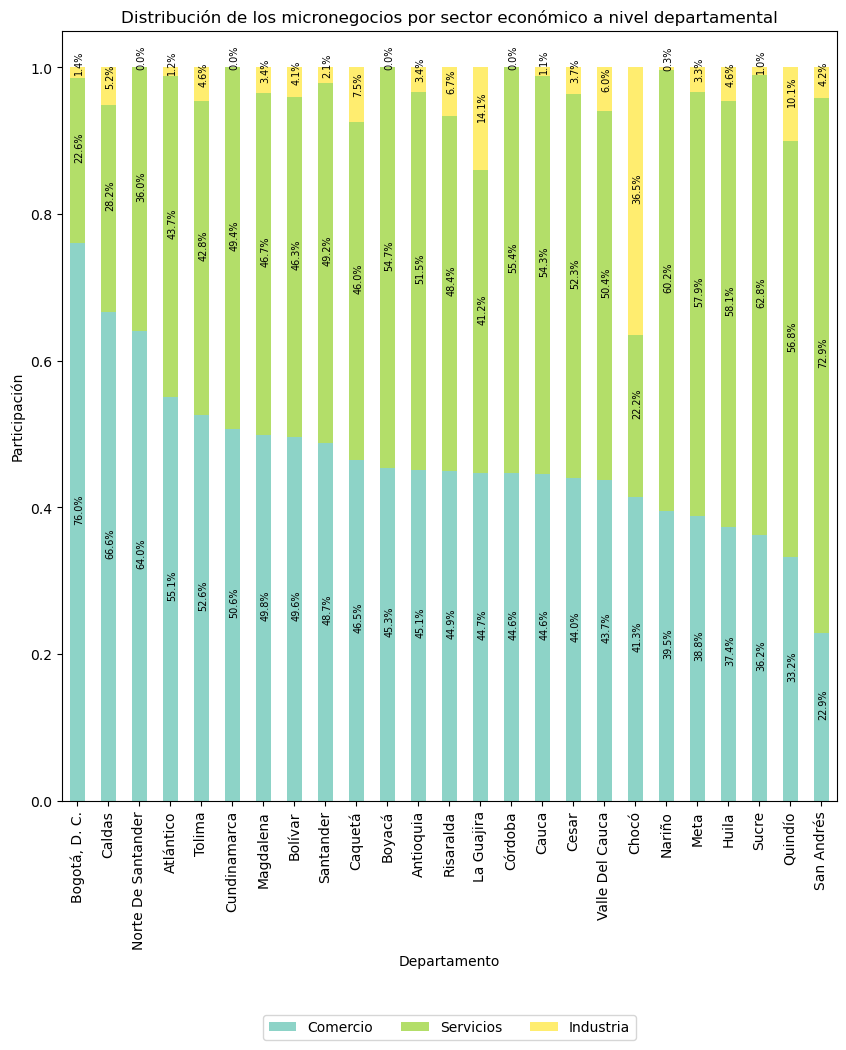

In [47]:
fig = crosstab_proporcion.plot.bar(stacked = True, 
                            colormap = "Set3",
                            figsize = (10, 10)).get_figure()# para guardar una imagen



for n, x in enumerate([*crosstab_proporcion.index.values]):
    for (proportion, y_loc) in zip(crosstab_proporcion.loc[x],
                                   crosstab_proporcion.loc[x].cumsum()):
                
        plt.text(x = n - 0.1,
                 y = (y_loc - proportion) + (proportion / 2),
                 s = f'{np.round(proportion * 100, 1)}%', 
                 color = "black",
                 fontsize = 7,
                 rotation = 'vertical')
                 #fontweight="bold")

plt.xlabel("Departamento")
plt.ylabel("Participación")
plt.title("Distribución de los micronegocios por sector económico a nivel departamental")
        
# Put a legend below current axis
plt.legend(loc ='lower center', bbox_to_anchor = (0.5, -0.32),
          fancybox = True, shadow = False, ncol = 5)

plt.show()

In [48]:
fig.savefig("D:/jupyter/dane/imagenes/moviles_distribucion_negocios_sect_dpto.png")

In [11]:
y_loc

1.0

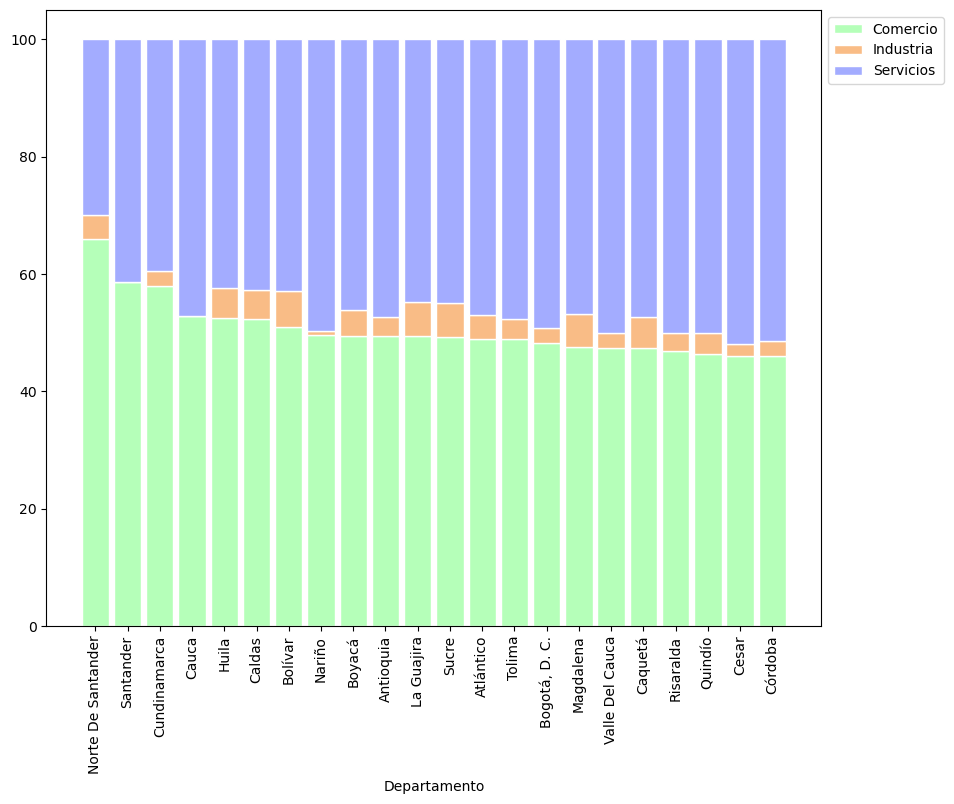

In [12]:
# From raw value to percentage
x = crosstab_proporcion.index
total = [i + j + k for i, j, k in zip(crosstab_proporcion['Comercio'], crosstab_proporcion['Industria'], crosstab_proporcion['Servicios'])]
comercio = [i / j * 100 for i, j in zip(crosstab_proporcion['Comercio'], total)]
industria = [i / j * 100 for i, j in zip(crosstab_proporcion['Industria'], total)]
servicios = [i / j * 100 for i, j in zip(crosstab_proporcion['Servicios'], total)]
 
# plot
barWidth = 0.85
nombres_dpto = crosstab_proporcion.index

fig = plt.figure(figsize = [10,8])

# Create green Bars
plt.bar(x, comercio, color='#b5ffb9', edgecolor='white', width = barWidth, label = 'Comercio')
# Create orange Bars
plt.bar(x, industria, bottom = comercio, color ='#f9bc86', edgecolor = 'white', width=barWidth, label = 'Industria')
# Create blue Bars
plt.bar(x, servicios, bottom = [i+j for i,j in zip(comercio, industria)], color = '#a3acff', edgecolor ='white', width = barWidth,label = 'Servicios')
 
# Custom x axis
plt.xticks(x, nombres_dpto, rotation = 90)
plt.xlabel("Departamento")
plt.legend(loc = 'upper left', bbox_to_anchor = (1,1), ncol = 1)

# Show graphic
plt.show()

# Ingresos

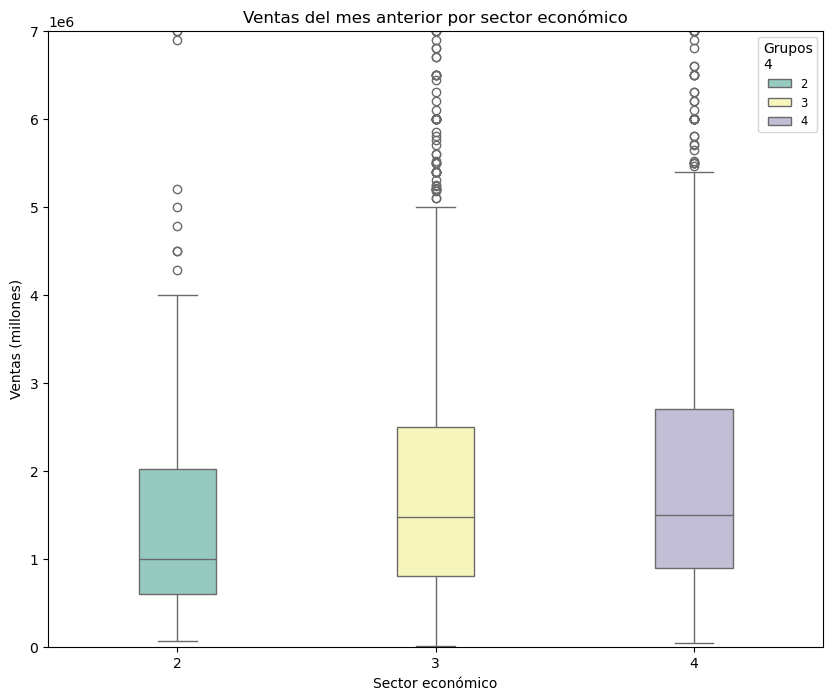

In [49]:
fig = plt.figure(figsize = [10, 8])
sns.boxplot(x = 'grupos4', y = 'ventas_mes_anterior', data = emicron_m22, palette = "Set3", hue = 'grupos4', width = 0.3)
plt.title("Ventas del mes anterior por sector económico")
plt.ylabel("Ventas (millones)")
plt.xlabel("Sector económico")
# q1, q3 = emicron_m22['ventas_mes_anterior'].describe()[[4,6]]
# plt.ylim((0, q3 + 1.5*(q3-q1)))
plt.ylim(0, 7000000)
plt.legend(loc = 'upper right', title = 'Grupos\n4', fontsize = 'small')
plt.show()


In [50]:
fig.savefig("D:/jupyter/dane/imagenes/moviles_ventas_mes_anterior.png")

# Personal empleado

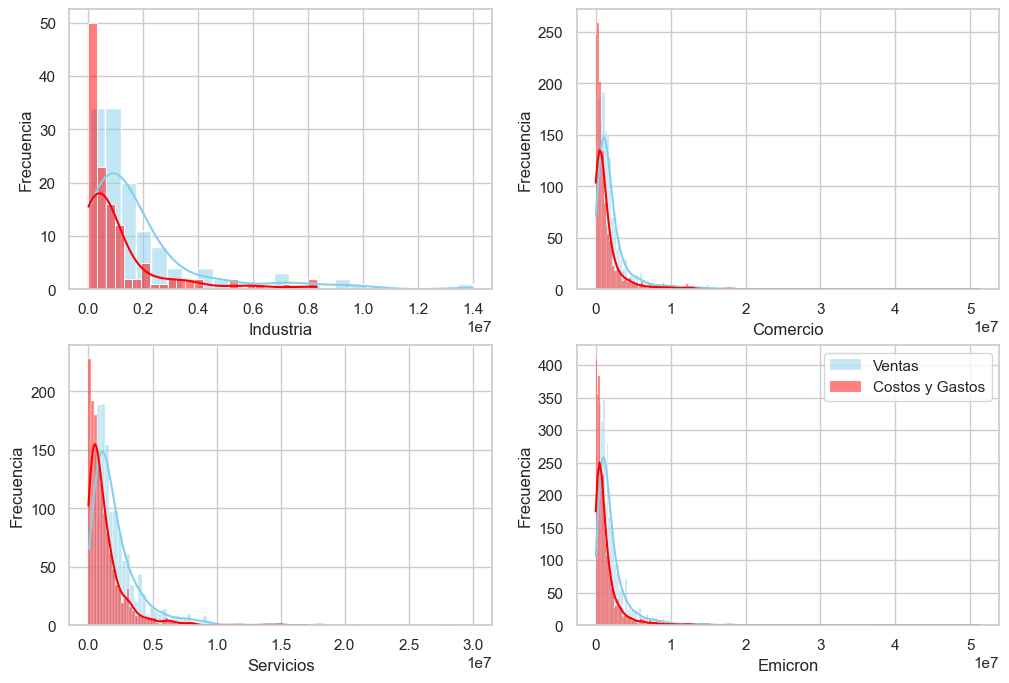

In [83]:
sns.set_theme(style = "whitegrid", palette = "pastel")
fig, ax = plt.subplots(2, 2, figsize = (12, 8)) 

sns.histplot(data = emicron_m[['ventas_mes_anterior', 'cyg']][emicron_m['grupos4'] == 2], x = 'ventas_mes_anterior', color ="skyblue", label = "Ventas industria", kde=True, ax = ax[0,0])
sns.histplot(data = emicron_m[['ventas_mes_anterior', 'cyg']][emicron_m['grupos4'] == 2], x = 'cyg', color ="red", label = "Costos y Gastos comercio", kde=True, ax = ax[0,0])
ax[0,0].set_xlabel("Industria")
ax[0,0].set_ylabel("Frecuencia")

sns.histplot(data = emicron_m[['ventas_mes_anterior', 'cyg']][emicron_m['grupos4'] == 3], x = 'ventas_mes_anterior', color ="skyblue", label = "Ventas comercio", kde=True, ax = ax[0,1])
sns.histplot(data = emicron_m[['ventas_mes_anterior', 'cyg']][emicron_m['grupos4'] == 3], x = 'cyg', color ="red", label = "Costos y Gastos comercio", kde=True, ax = ax[0,1])
ax[0,1].set_xlabel("Comercio")
ax[0,1].set_ylabel("Frecuencia")

sns.histplot(data = emicron_m[['ventas_mes_anterior', 'cyg']][emicron_m['grupos4'] == 4], x = 'ventas_mes_anterior', color ="skyblue", label = "Ventas servicios", kde=True, ax = ax[1,0])
sns.histplot(data = emicron_m[['ventas_mes_anterior', 'cyg']][emicron_m['grupos4'] == 4], x = 'cyg', color ="red", label = "Costos y Gastos servicios", kde=True, ax = ax[1,0])
ax[1,0].set_xlabel("Servicios")
ax[1,0].set_ylabel("Frecuencia")

sns.histplot(data = emicron_m[['ventas_mes_anterior', 'cyg']], x = 'ventas_mes_anterior', color ="skyblue", label = "Ventas", kde=True, ax = ax[1,1])
sns.histplot(data = emicron_m[['ventas_mes_anterior', 'cyg']], x = 'cyg', color ="red", label = "Costos y Gastos", kde=True, ax = ax[1,1])
ax[1,1].set_xlabel("Emicron")
ax[1,1].set_ylabel("Frecuencia")

ylabel = ('')

plt.legend()
plt.show()

In [84]:
fig.savefig("D:/jupyter/dane/imagenes/ventas_vs_cyg.png")

In [54]:
emicron_m[['ventas_mes_anterior', 'cyg']][emicron_m['grupos4'] == 2]

,ventas_mes_anterior,cyg
24,550000,100000
27,1700000,940000
33,1800000,1000000
52,5200000,3590000
56,375000,270000
...,...,...
2951,900000,100000
2964,3312000,2112000
3007,850000,400000
3023,1700000,925000
